# Exercise 8 - Image Processing 2
## Feb. 07, 2024

## **In-class poll: https://pollev.com/guysinger472** 

![Screenshot 2024-02-07 at 13.21.57.png](<attachment:Screenshot 2024-02-07 at 13.21.57.png>)

## Agenda:
- Singular Value Decomposition
- In-class programming exercise: SVD for denoising images
- 2D Fourier Space
- In-class programming exercise: fourier transforms of images
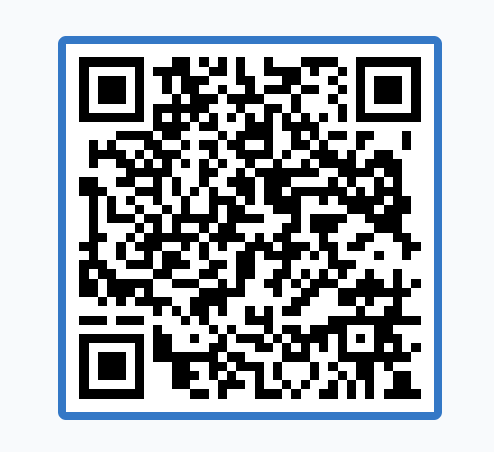

In [1]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from skimage import io

## Singular Value Decomposition (SVD)

### Youtube Video: [https://www.youtube.com/watch?v=gXbThCXjZFM](https://www.youtube.com/watch?v=gXbThCXjZFM)

### Youtube Video: [https://www.youtube.com/watch?v=vSczTbgc8Rc](https://www.youtube.com/watch?v=vSczTbgc8Rc)

### Linear Algebra Background

For a matrix $A$ with $n$ rows and $m$ columns, we define _eigenvectors_ and _eigenvalues_ using this equation:

$
A\vec{v} = \lambda \vec{v}
$

For $\vec{v}$ to be the eigenvectors of $A$, they have to be non-zero and to satisfy this equation, which also consists of the eigenvalues $\lambda$. To find these eigenvalues and eigenvectors we solve this equation as a set, or system, of linear equations. We won't go into these details (all of you should be vaguely aware of them), but after the calculation, generally each eigenvalue will have an eigenvector.

For example, a specific matrix:

$
A = \begin{bmatrix}
2 & 1 \\
1 & 2
\end{bmatrix}
$

has an eigenvalue of $\lambda_1=3$ with an eigenvector of $\vec{v}_1=[1,1]$, and an eigenvalue of $\lambda_2=1$ with an eigenvector of $\vec{v}_2=[1,-1]$.

A theorem in linear algebra states a square matrix $A$ is diagonalizable if we can decompose it to $A=PDP^{-1}$, with $D$ being diagonal. From this follows that the columns of $P$ are its eigenvectors, and the values along the diagonal in $D$ are the eigenvalues. Of course, not all matrices are diagonalizable, since they don't always have eigenvectors that form a basis. SVD takes this concept one further step, by generalizing it to all matrices.

### Mathematical Expression of SVD

SVD breaks down a matrix into three simpler matrices, revealing many of the matrix's fundamental properties, such as rank and eigenvalues. This decomposition plays a crucial role in image compression, noise reduction, and data reduction techniques in neuroscience and biology. Let's dive into what SVD is and its components.

Singular Value Decomposition of a matrix $A$ is a method of decomposing $A$ into three special matrices:

$A = U\Sigma V^T$

Here's what each component represents:
- $A$ is any $m \times n$ real or complex matrix we want to decompose.
- $U$ is an $m \times m$ matrix, where the columns are orthogonal vectors of $A$'s column space.
- $\Sigma$ (Sigma) is an $m \times n$ diagonal matrix containing singular values of $A$ that are non-negative. These values are sorted in descending order.
- $V^T$ is the transpose of an $n \times n$ matrix, $V$, where the columns are orthogonal vectors of $A$'s row space.

### Definitions

- **Orthogonal Matrices**: A matrix is orthogonal if its columns and rows are orthogonal unit vectors (meaning they are perpendicular and have a magnitude of 1). The beauty of orthogonal matrices is that multiplying by its transpose results in the identity matrix, a key property that simplifies many mathematical operations.

- **Diagonal Matrix**: A matrix is diagonal if all entries outside the main diagonal are zero. The singular values in $\Sigma$ are placed on this diagonal.

- **Singular Values**: These are the diagonal entries of $\Sigma$. They give insight into the "importance" or "weight" of each corresponding vector in matrices $U$ and $V$. In image processing, larger singular values represent more significant features of the image, while smaller values often correspond to noise or less important details.

### Calculating SVD

We start of with the fact that the matrix $A^T A$ is symmetric, and thus its eigenvectors $x_i$ form an orthonormal basis. Assuming that their corresponding eigenvalues are $\lambda_i$, we will define $\sigma_i = \sqrt{\lambda_i}$ (these are the singular values), and another vector will be denoted as $r_i = \frac{Ax_i}{\sigma_i}$.

These quantities will construct three matrices that decompose $A$: $U$ will have $r_i$ as its columns, $V$ will have $x_i$ as its columns, and $\Sigma$ will have $\sigma_i$ as its diagonal, padded with zeros if necessary. To prove that
$$
A_{mn} = U_{mm} \Sigma_{mn} V^T_{nn} \\
$$
we'll see what is the result of the multiplication done on the right-hand side:

$$
U\Sigma = \frac{Ax_i}{\sigma_i}\sigma_i = Ax_i
$$

The next step is to multiply $U\Sigma$ by $V^T$. The columns are $Ax_i$, and the rows are of the form $x_j$. Since the eigenvectors are orthonormal, if $i \neq j$ then $x_i x_j^T = 0$, and for $i = j$ we have $x_i x_i^T = 1$, which yields

$$
U\Sigma V^T = AI = A
$$

In summary, we were able to write an arbitrary matrix $A$ using three different matrices, with $U$ and $V$ having orthonormal columns and $\Sigma$ being a diagonal matrix composed of singular values.

### Importance of SVD in Image Processing

In image processing, SVD is used for:
- **Image Compression**: By selecting only the largest singular values and discarding smaller ones, we can approximate the original image with fewer data, reducing storage and transmission requirements.
- **Noise Reduction**: Smaller singular values are often associated with noise. By eliminating them, we can clean up the image while preserving essential features.
- **Feature Extraction**: SVD helps in identifying and extracting features from images, useful in pattern recognition and machine learning applications.

To appreciate the depth of SVD, let's walk through how the rank of a matrix $A$, denoted as $\text{rank}(A)$, is equal to the number of its nonzero singular values. This involves understanding the role of $\Sigma$, the effects of orthogonal transformations ($U$ and $V$), and how these concepts interplay to preserve the rank during decomposition.

Let $A \in \mathbb{R}^{m \times n}$ have the SVD $A = U\Sigma V^T$, where:

- The ith largest singular value of $A$ is $\sigma_i$. The number of nonzero singular values of $A$ is $r$
- $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal matrices.
- $\Sigma \in \mathbb{R}^{m \times n}$ is a diagonal matrix with singular values $\sigma_1, \sigma_2, ..., \sigma_p$ on the diagonal ($p = \min(m,n)$), where the first $r$ singular values are positive ($\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_r > 0$) and the rest are zero.

$A = U\Sigma V^T$

$\text{rank}(A) = \text{dim}(\text{Col}(A))$, where $\text{Col}(A)$ represents the column space of $A$. This corresponds to the maximum number of linearly independent columns of $A$.

$\Sigma$ diagonal implies $A$ has $r$ nonzero singular values $\Rightarrow \Sigma = \text{diag}(\sigma_1, \sigma_2, ..., \sigma_r, 0, ..., 0)$.

$\text{rank}(\Sigma) = r$ because it has $r$ nonzero entries on its diagonal, which are linearly independent.

For orthogonal matrices $U$ and $V$, $\text{rank}(U\Sigma V^T) = \text{rank}(\Sigma)$ since orthogonal transformations preserve linear independence and vector space dimensions.

Therefore, $\text{rank}(A) = \text{rank}(\Sigma) = r$

## In-Class Programmign Exercise: SVD on Images

1. `a = np.random.randn(9, 6)`: This line generates a $9 \times 6$ matrix `a` filled with random numbers drawn from a standard normal distribution (mean 0, variance 1). This matrix serves as an example data set, which could represent an image or any other two-dimensional data in real applications.

2. `plt.pcolor(a)`: This command uses Matplotlib's `pcolor` function to create a pseudocolor plot of the matrix `a`. Each cell in the plot represents a value in the matrix with a color determined by the value's magnitude.

3. `U, s, V = linalg.svd(a, full_matrices=False)`: This line computes the Singular Value Decomposition of the matrix `a` using the `svd` function from a linear algebra library. The `full_matrices=False` argument specifies that `U` and `V` should be returned in their reduced forms, making the shapes of `U`, `s`, and `V` compatible for reconstruction of the original matrix. The function returns:
   - `U`: An $m \times m$ orthogonal matrix where $m$ is the number of rows in `a`.
   - `s`: A vector containing the singular values of `a`, sorted in descending order.
   - `V`: The transpose of an $n \times n$ orthogonal matrix where $n$ is the number of columns in `a`.

4. `U.shape, s.shape, V.shape`: This line outputs the shapes of `U`, `s`, and `V` to verify their dimensions. Since `full_matrices=False`, `U` and `V` are not square matrices but are instead sized to match the dimensions of `a`, and `s` is a 1-dimensional array with a length equal to the smaller dimension of `a`.

((9, 6), (6,), (6, 6))

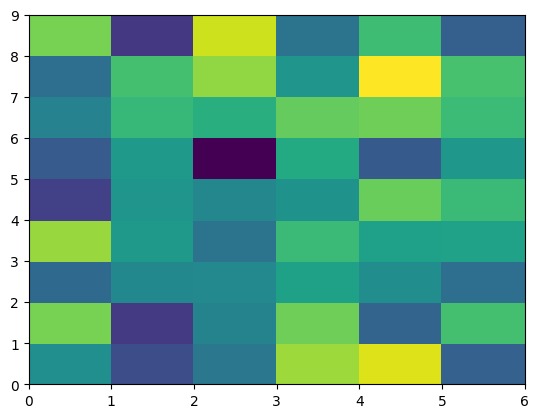

In [2]:
a = np.random.randn(9, 6)
plt.pcolor(a)
U, s, V = linalg.svd(a, full_matrices=False)
U.shape, s.shape, V.shape

Now we reconstruct the original matrix from its SVD components and visualizes the reconstructed matrix:

1. `S = linalg.diagsvd(s, U.shape[1], U.shape[1])`: This command constructs a diagonal matrix `S` from the singular values in `s`. The `diagsvd` function is used to create a matrix with `s` on its diagonal and zeros elsewhere. The dimensions of `S` are set to match those required for matrix multiplication with `U` and `V`.

2. `a_calc = U @ S @ V`: This line reconstructs the original matrix `a` by performing matrix multiplication of `U`, `S`, and `V`. The `@` operator is used for matrix multiplication in Python. This operation effectively combines the singular values (encoded in `S`) with the orthogonal matrices `U` and `V` to reproduce the original matrix.

3. `plt.pcolor(a_calc)`: Finally, the reconstructed matrix `a_calc` is visualized using `pcolor` in a manner identical to the original matrix. This plot should appear very similar or identical to the plot of the original matrix, demonstrating that the SVD decomposition and subsequent reconstruction accurately capture the original data.

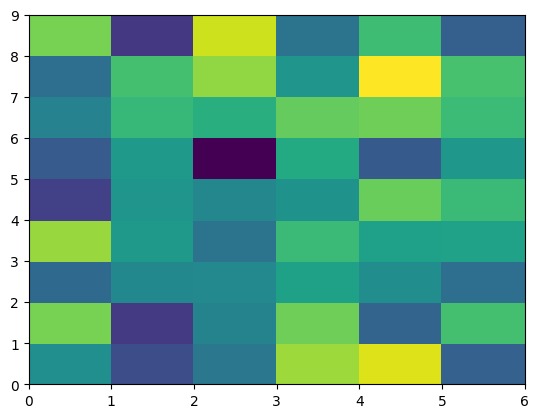

In [3]:
S = linalg.diagsvd(s, U.shape[1], U.shape[1])
a_calc = U @ S @ V 
plt.pcolor(a_calc)

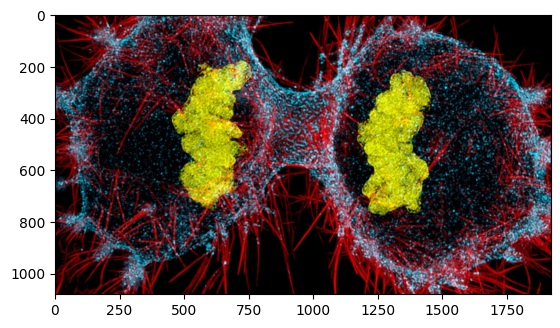

In [6]:
im = plt.imread(r'meiosis.jpg')
plt.imshow(im)

#### Visualizing Singular Values: The singular values s are plotted on the y-axis in logarithmic scale, with their indices on the x-axis. This visualization helps in understanding the distribution and magnitude of the singular values. In many images, a small number of singular values are significantly larger than the rest, indicating that a few components capture most of the image's essential information. This plot can be used to assess how many singular values (or components) are needed to approximate the original image effectively, a technique useful in image compression and noise reduction.

Text(0.5, 1.0, 'Log scale of magnitude of SVD components')

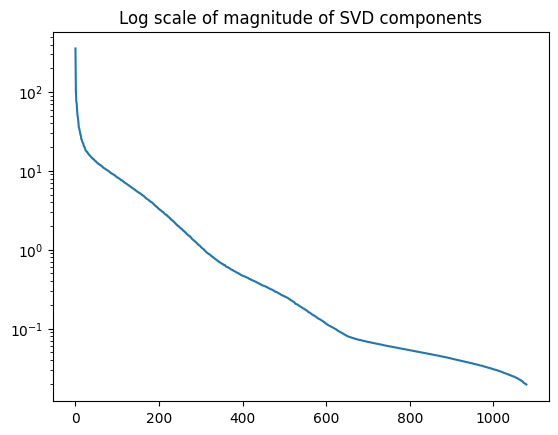

In [9]:
from skimage import color

gray_im = color.rgb2gray(im)

U, s, V = linalg.svd(gray_im)
plt.semilogy(s)
plt.title('Log scale of magnitude of SVD components')

Text(0.5, 1.0, 'Cumulative percent of total singular values')

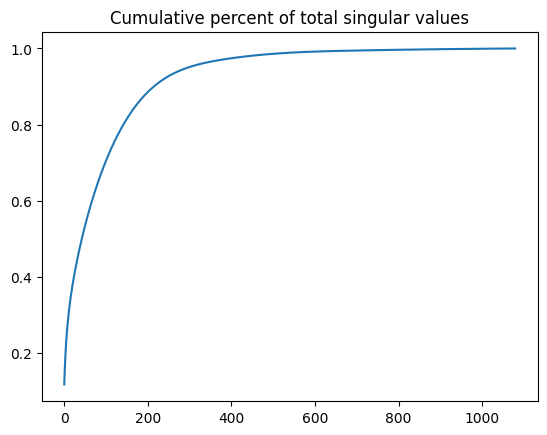

In [10]:
plt.plot(np.cumsum(s)/ np.sum(s))
plt.title('Cumulative percent of total singular values')

In [ ]:
num_of_ranks = [3, 10, 20, 50, 100, 200]

for idx, cur_ranks in enumerate(num_of_ranks):
    cur_sigmas = s.copy()
    cur_sigmas[cur_ranks:] = 0  # Subset of the ranks
    S = linalg.diagsvd(cur_sigmas, U.shape[1], V.shape[1])
    approx_owl = U @ S @ V  # Recreate the owl
    # Plotting
    plt.subplot(3, 2, idx+1)
    plt.imshow(approx_owl, cmap='gray')
    plt.title('Rank {} owl'.format(cur_ranks))
    plt.axis('off')

plt.tight_layout()

## Fourier Transforms: From 1D to 2D

The 2D Fourier Transform converts an image from the spatial domain (where each pixel's position and intensity are represented) into the frequency domain (where the image is represented by its frequency components), essentially showing how the image's intensity varies over space. High-frequency components correspond to rapid intensity changes, which are typically found at edges and fine details in the image. Low-frequency components represent slow changes in intensity, often associated with broad areas of similar color or intensity.

This transformation allows for the analysis and manipulation of the image in ways that are not always intuitive or possible in the spatial domain.

### Key Applications in Image Processing

1. **Image Filtering**: One of the primary applications of the Fourier Transform in image processing is filtering. High-pass filters can remove low-frequency components (smoothing out variations and retaining edges), while low-pass filters can remove high-frequency noise. This is done by transforming the image into the frequency domain, modifying the frequency components (by attenuating or amplifying certain frequencies), and then performing an inverse Fourier Transform to convert the image back into the spatial domain.

2. **Image Compression**: The Fourier Transform can also be used in image compression. Since many images have significant low-frequency components and fewer high-frequency components, one can compress an image by keeping only the most significant frequencies and discarding the rest. This is the basis of some image compression algorithms, where the image is transformed, insignificant frequencies are removed, and the image is reconstructed from the remaining components.

3. **Pattern Recognition and Feature Extraction**: In the frequency domain, specific patterns or features within an image might become more apparent or easier to isolate than in the spatial domain. For example, periodic patterns in an image translate into distinct peaks in the frequency domain, which can be identified and analyzed for applications such as texture analysis or object recognition.

4. **Image Registration and Stitching**: Fourier Transform methods can be used to determine the relative translation, rotation, and scaling between images, useful in applications like image stitching where multiple images need to be aligned and combined into a single panoramic image.

5. **Noise Reduction and Enhancement**: By identifying and filtering out frequencies that correspond to noise, the Fourier Transform can be used to enhance image quality. Similarly, enhancing specific frequency components can bring out details that are not easily seen in the original image.

### Practical Considerations

- **Fast Fourier Transform (FFT)**: The FFT is an efficient algorithm for computing the Fourier Transform, crucial for processing large images quickly.

- **Aliasing and Artifacts**: Care must be taken when applying and inversely applying the Fourier Transform to avoid introducing artifacts or aliasing into the image.

- **Windowing**: Applying a window function to the image before performing the Fourier Transform can reduce edge effects and improve the analysis of frequency components.

- **Visualization**: Visualizing the magnitude and phase of the Fourier Transform provides insight into the frequency content and spatial relationships within the image. However, because the dynamic range of frequency components can be large, logarithmic scaling is often used to visualize the spectrum.

In summary, the 2D Fourier Transform is a powerful tool in image processing, enabling sophisticated operations that take advantage of the image's frequency content. Its applications range from basic filtering and noise reduction to more complex tasks like image compression and feature extraction, illustrating its central role in modern image analysis and processing techniques.

The continuous and inverse transforms:

$
F(\omega)=\frac{1}{2\pi}\int_{-\infty}^{\infty}{f(t)e^{-i\omega t}}dt
$

$
f(t) = \int_{-\infty}^{\infty}{F(\omega) e^{i\omega t} dt}
$

The discrete transform is very similar:

$
F[k] = \sum_{n=0}^{N-1}{f[n] \exp{\left(-i \frac{2\pi n k}{N}\right)}} \ ; \ k \in [0, N-1]
$

$
f[n] = \frac{1}{N} \sum^{N-1}_{k=0}{F[k]}\exp{\left(\frac{{2\pi i k n}}{N}\right)} \ ; \ n \in [0, N-1]
$

Generalizing the Fourier formula to two dimensions is pretty trivial:

$
F[k,l] = \sum_{n_1=0}^{N-1} \sum_{n_2=0}^{M-1}{f[n_1,n_2] \exp{\left( -2 \pi i \left( \frac{kn_1}{N} + \frac{ln_2}{M} \right) \right)}}
$

That being said, we're obviously not going to prove it here. 

In most implementations, the Fourier image is shifted so that the DC-value (i.e., the image mean) F(0,0) is at the center of the image. This positioning implies that frequencies increase in value as they move further from the center.

Keeping Euler's formula in mind,

$$
e^{i\theta} = \cos \theta + i \sin \theta
$$
we can write the DFT of the signal in a different way (reverting to 1D for ease of explanation):

$$
F[k] = \sum_{n=0}^{N-1}{f[n] \left( \cos(2\pi k n / N) - i\sin (2\pi k n / N) \right)}
$$
allowing us to identify the real and imaginary part of a Fourier-transformed signal more easily. Writing it in polar coordinates results in:

$$
F[k] = \left| F[k] \right| e^{-i\phi(k)}
$$
where 

$$
\left| F[k] \right| = \left[ \Re^2(k) + \Im^2(k) \right]^{1/2}
$$
is the _magnitude_ of the Fourier transform, and

$$
\phi(k) = \tan^{-1} \left[ \frac{\Im(k)}{\Re(k)} \right]
$$
is the _phase_. Note that $\Re$ denotes the real part of the signal, and $\Im$ the imaginary. Another useful definition, which we've already seen as well, is the _power spectrum_:

$$
P(k) = \left| F[k] \right|^2 = \Re^2(k) + \Im^2 (k)
$$
sometimes normalized by $N$.

For real signals, like our images, the transform is conjugate symmetric: 

$$
F[k,l] = F^*[-k, -l] \Rightarrow \left| F[k,l] \right| = \left| F[-k,-l] \right|
$$

That's why shifting the $(0,0)$ point of the transform, that indicates the DC signal, to the center of the image is so common - it creates a symmetric image in the Fourier plane. The DC component is:

$$
F[0,0] = \frac{1}{MN}\sum_{n_1=0}^{N} \sum_{n_2=0}^{M} {f[n_1, n_2]}
$$
which is just the average of the 2D function across space.

### Example: The Boxcar Function

The boxcar function, also known as a rectangular pulse, is defined as being equal to one within a certain interval and zero elsewhere. When we apply a Fourier Transform to this function, we obtain a sinc function in the frequency domain. The sinc function, defined as $ \text{sinc}(x) = \frac{\sin(\pi x)}{\pi x} $, represents the distribution of frequency components in the rectangular pulse.

The Fourier transform of a rectangular pulse (boxcar):

$
f(t) = \begin{cases}
A, & -W/2 < t < W/2 \\
0, & \text{else}
\end{cases} \\
F(\omega) = \int_{- \infty}^{\infty}{f(t)e^{-2 \pi i \omega t}dt} = \int_{-W/2}^{W/2}{Ae^{-2 \pi i \omega t}dt}$

$
= AW \frac{\sin{(\pi \omega W)}}{\pi \omega W} = AW \text{sinc}(\pi \omega W)
$

The key insights from the Fourier Transform of a boxcar function include:
- **Main Lobe and Side Lobes**: The sinc function has a central peak (main lobe) and a series of decreasing oscillations (side lobes) on either side. The main lobe represents the dominant frequency component, while the side lobes indicate smaller frequency contributions.
- **Width Relationship**: There's an inverse relationship between the width of the boxcar in the time domain and the width of the main lobe of the sinc function in the frequency domain. A wider boxcar results in a narrower main lobe, and vice versa.
- **Gibbs Phenomenon**: The oscillations (side lobes) around the main lobe never fully settle to zero, a manifestation of the Gibbs phenomenon, which is common in the Fourier Transform of functions with sudden changes (discontinuities).

In image processing, understanding the Fourier Transform of shapes like a boxcar function helps in analyzing and processing images with similar features. For instance, knowing how edges and rectangular patterns translate into frequency components can guide techniques in filtering, compression, and feature extraction.


1. **Generate a 2D Boxcar Function**: Create a matrix representing the image with a rectangular region set to one (the boxcar) and the rest set to zero.

2. **Apply Fourier Transform**: Use the `fft2` function from a library like NumPy or SciPy to compute the 2D Fourier Transform of the boxcar image.

3. **Shift Zero Frequency to Center**: For visualization purposes, it's common to shift the zero frequency component to the center of the spectrum using the `fftshift` function.

4. **Visualize Frequency Spectrum**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

def create_rectangular_pulse(size, pulse_width):
    pulse = np.zeros(size)
    start_point = (size[0]//2 - pulse_width[0]//2, size[1]//2 - pulse_width[1]//2)
    pulse[start_point[0]:start_point[0]+pulse_width[0], start_point[1]:start_point[1]+pulse_width[1]] = 1
    return pulse
image_size = (256, 256)
pulse_width = (40, 80)
rect_pulse = create_rectangular_pulse(image_size, pulse_width)

ft_rect_pulse = fft2(rect_pulse)
ft_rect_pulse_shifted = fftshift(ft_rect_pulse) 

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(rect_pulse, cmap='gray')
axs[0].set_title('Original Rectangular Pulse')
axs[0].axis('off')

axs[1].imshow(np.log1p(np.abs(ft_rect_pulse_shifted)), cmap='gray')
axs[1].set_title('Magnitude of Fourier Transform')
axs[1].axis('off')

plt.show()


### Examples with Magnitude and Phase

In most implementations, the Fourier image is shifted so that the DC-value (i.e., the image mean) F(0,0) is at the center of the image. This positioning implies that frequencies increase in value as they move further from the center.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from urllib.request import urlopen

# Load the image from the web
resp = urlopen('https://homepages.inf.ed.ac.uk/rbf/HIPR2/images/cln1.gif')
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)

# Apply Fourier Transform
f_transform = np.fft.fft2(image)
f_shift = np.fft.fftshift(f_transform)
magnitude_spectrum = 20 * np.log(np.abs(f_shift))

# Display the original and magnitude spectrum
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(image, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

The magnitude spectrum reveals that the DC-value is the largest component, indicating it has a wide dynamic range. To better visualize other components, we apply a logarithmic transformation:

In [ ]:
# Apply logarithmic transformation to enhance visibility
magnitude_spectrum_log = np.log(1 + np.abs(f_shift))

plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum_log, cmap='gray')
plt.title('Log Transformed Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

This transformation highlights the presence of components across all frequencies, with their magnitude decreasing at higher frequencies. Notably, the image shows two dominant directions, vertical and horizontal, which correspond to the regular patterns in the background of the original image.

The phase component also plays a crucial role in the Fourier Transform:

Although the phase image doesn't provide much new information about the spatial structure, it is essential for reconstructing the original image accurately.

In [ ]:
# Display the phase of the Fourier transform
phase_spectrum = np.angle(f_shift)

plt.figure(figsize=(6, 6))
plt.imshow(phase_spectrum, cmap='gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Ignoring the phase information and applying the inverse Fourier Transform demonstrates the significance of the phase:

This process illustrates that even if the magnitude spectrum contains the correct frequencies, ignoring the phase results in an image that is unrecognizable. Thus, phase information is crucial for accurately reconstructing the original image in the spatial domain.

In [ ]:
# Inverse Fourier Transform without phase
magnitude_only = np.abs(f_shift)
reconstructed_image = np.fft.ifft2(np.fft.ifftshift(magnitude_only)).real

# Histogram equalization for better visualization
reconstructed_image_eq = cv2.equalizeHist(np.uint8(reconstructed_image))

plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image_eq, cmap='gray')
plt.title('Reconstructed Image Without Phase'), plt.xticks([]), plt.yticks([])
plt.show()

## Examples with "real" images

### Hubble deep field

In [12]:
from skimage import data
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from skimage import transform
%matplotlib inline

Text(0.5, 1.0, 'Hubble Deep Field')

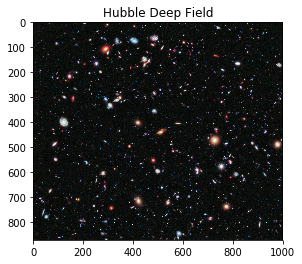

In [13]:
hubble = data.hubble_deep_field()
plt.imshow(hubble, cmap='viridis')
plt.title('Hubble Deep Field')

Text(0.5, 1.0, 'Fourier transform of many delta functions')

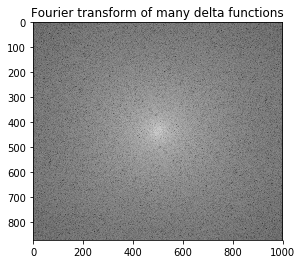

In [14]:
hubble_fourier = fftpack.fftshift(fftpack.fft2(color.rgb2gray(hubble)))
hubble_fourier_abs = np.power(np.abs(hubble_fourier), 2)
plt.imshow(np.log10(hubble_fourier_abs), cmap='gray')
plt.title('Fourier transform of many delta functions')

We see her some sort of averaging of many point-like structures, resulting in a smeared pattern of a delta function.

### Cup of coffee

Text(0.5, 1.0, 'Cup of coffee')

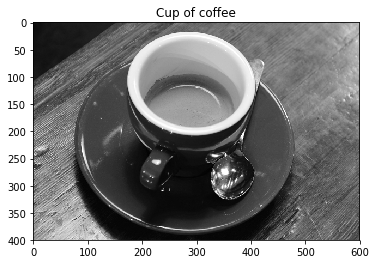

In [15]:
cof = data.coffee()
plt.imshow(color.rgb2gray(cof), cmap='gray')
plt.title('Cup of coffee')

Text(0.5, 1.0, 'Magnitude of Fourier transform of the cup of coffee')

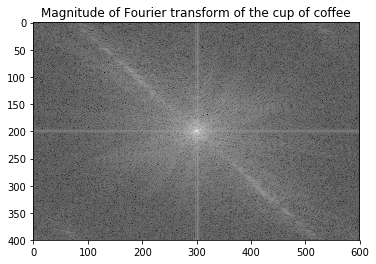

In [16]:
cof_fourier = fftpack.fftshift(fftpack.fft2(color.rgb2gray(cof)))
cof_fourier_abs = np.power(np.abs(cof_fourier), 2)
plt.imshow(np.log10(cof_fourier_abs), cmap='gray')
plt.title('Magnitude of Fourier transform of the cup of coffee')

### Phase spectrum

Let's observe the phase of the transformed image:

Text(0.5, 1.0, 'The phase spectrum of the cup of coffee')

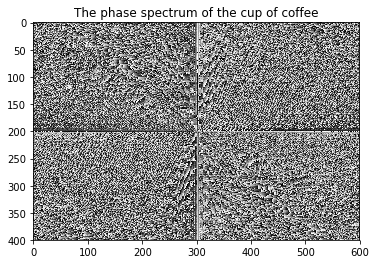

In [17]:
cof_fourier_phase = np.angle(cof_fourier)  # Same in Matlab
plt.imshow(cof_fourier_phase, cmap='gray')
plt.title('The phase spectrum of the cup of coffee')

It's obviously indiscernible. The nice thing about the frequency spectrum is that it contains more information than the magnitude spectrum for visualization. Let's switch the phase and magnitude of the cup of two images, and see what we get (think of how are we about to do it):

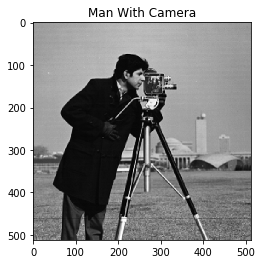

In [18]:
camera = data.camera()
plt.imshow(camera, cmap='gray')
plt.title('Man With Camera')

# Take the phase spectrum only
camera_fourier = fftpack.fft2(camera)
camera_phase = np.angle(camera_fourier)

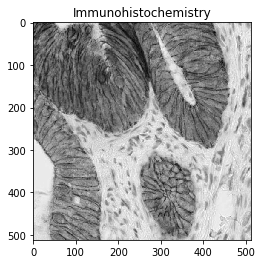

In [19]:
ihc = data.immunohistochemistry()
ihc = ihc[:,:,1]
plt.imshow(ihc, cmap='gray')
plt.title('Immunohistochemistry')

# Take the magnitude spectrum only
ihc_fourier = fftpack.fft2(ihc)
ihc_mag = np.abs(ihc_fourier)

Text(0.5, 1.0, 'The phase prevails')

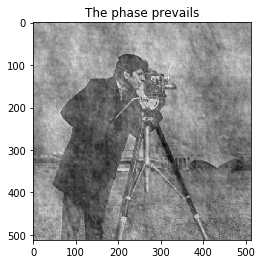

In [21]:
switched_fourier = ihc_mag * np.exp(1j * camera_phase)
# Inverse it back
switched_image = fftpack.ifft2(switched_fourier)
plt.imshow(np.real(switched_image), cmap='gray')
plt.title('The phase prevails')